In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
train = pd.read_csv("train.csv")
leaderboard = pd.read_csv("leaderboard_dataset.csv")
test = pd.read_csv("test.csv")

In [3]:
y = train["VAR21"]
X = train.drop(["VAR21"], axis=1)

In [4]:
from sklearn.preprocessing import LabelEncoder

for c in X.columns:
    if X[c].dtype == 'object':
        lbl = LabelEncoder() 
        lbl.fit(list(X[c].values) + list(test[c].values) + list(leaderboard[c].values)) 
        X[c] = lbl.transform(list(X[c].values))
        test[c] = lbl.transform(list(test[c].values))
        leaderboard[c] = lbl.transform(list(leaderboard[c].values))

In [5]:
lbl = LabelEncoder() 
lbl.fit(list(y.values)) 
y = lbl.transform(list(y))

In [6]:
y

array([1, 0, 2, ..., 1, 1, 0])

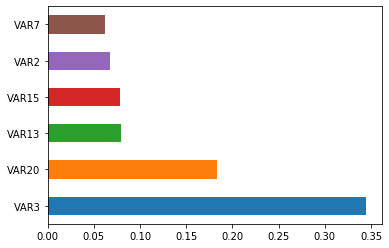

In [115]:
from imblearn.ensemble import BalancedRandomForestClassifier

clf = BalancedRandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X, y)
clf.feature_importances_

(pd.Series(clf.feature_importances_, index=X.columns)
   .nlargest(6)
   .plot(kind='barh'))

In [116]:
a = pd.Series(clf.feature_importances_, index=X.columns).nlargest(10)
b = a.index.get_values().tolist()

In [117]:
b.append("VAR1")
b

['VAR3',
 'VAR20',
 'VAR13',
 'VAR15',
 'VAR2',
 'VAR7',
 'VAR16',
 'VAR4',
 'VAR12',
 'VAR8',
 'VAR1']

In [118]:
X = X[b]
leaderboard = leaderboard[b]
test = test[b]

In [119]:
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
from sklearn.decomposition import PCA, FastICA
from sklearn.decomposition import TruncatedSVD
n_comp = 4

# tSVD
tsvd = TruncatedSVD(n_components=n_comp, random_state=420)
tsvd_results_X = tsvd.fit_transform(X)
tsvd_results_test = tsvd.transform(test)
tsvd_results_leaderboard = tsvd.transform(leaderboard)

# PCA
pca = PCA(n_components=n_comp, random_state=420)
pca2_results_X = pca.fit_transform(X)
pca2_results_test = pca.transform(test)
pca2_results_leaderboard = pca.transform(leaderboard)

# ICA
ica = FastICA(n_components=n_comp, random_state=420)
ica2_results_X = ica.fit_transform(X)
ica2_results_test = ica.transform(test)
ica2_results_leaderboard = ica.transform(leaderboard)

#X_trans = X[["VAR1"]]
#leaderboard_trans = leaderboard[["VAR1"]]
#test_trans = test[["VAR1"]]

# Append decomposition components to datasets
for i in range(1, n_comp+1):
    X_trans['pca_' + str(i)] = pca2_results_X[:,i-1]
    test_trans['pca_' + str(i)] = pca2_results_test[:, i-1]
    leaderboard_trans['pca_' + str(i)] = pca2_results_leaderboard[:, i-1]
    
    X_trans['ica_' + str(i)] = ica2_results_X[:,i-1]
    test_trans['ica_' + str(i)] = ica2_results_test[:, i-1]
    leaderboard_trans['ica_' + str(i)] = ica2_results_leaderboard[:, i-1]

    X_trans['tsvd_' + str(i)] = tsvd_results_X[:,i-1]
    test_trans['tsvd_' + str(i)] = tsvd_results_test[:, i-1]
    leaderboard_trans['tsvd_' + str(i)] = tsvd_results_leaderboard[:, i-1]

In [8]:
import xgboost as xgb

# prepare dict of params for xgboost to run with
xgb_params = {
    'n_trees': 2000, 
    'eta': 0.001,
    'max_depth': 6,
    'subsample': 0.925,
    'objective': 'multi:softmax',
    'eval_metric': 'mlogloss',
    'silent': 1,
    'num_class' :3
}

# form DMatrices for Xgboost training
dtrain = xgb.DMatrix(X.drop(["VAR1"], axis=1), y)
dtest = xgb.DMatrix(leaderboard.drop(["VAR1"], axis=1))

# xgboost, cross-validation
cv_result = xgb.cv(xgb_params, 
                   dtrain, 
                   num_boost_round=10000, # increase to have better results (~700)
                   verbose_eval=50,
                   early_stopping_rounds=50
                  )

num_boost_rounds = len(cv_result)
print('num_boost_rounds=' + str(num_boost_rounds))

# train model
model = xgb.train(dict(xgb_params, silent=1), dtrain, num_boost_round=num_boost_rounds)


# check f2-score (to get higher score - increase num_boost_round in previous cell)

# make predictions and save results
y_preds = model.predict(dtest)

d = {'col1': leaderboard["VAR1"], 'col2': [int(i) for i in y_preds]}
df = pd.DataFrame(data=d)
df["col2"][df["col2"] == 0] = "High"
df["col2"][df["col2"] == 1] = "Low"
df["col2"][df["col2"] == 2] = "Medium"

import shutil 

filename = "Quant404_IITGuwahati_45"
df.to_csv(filename+'.csv', index=False, header=False)
shutil.copyfile("Quant404_IITGuwahati_12-Copy2.ipynb", filename+".ipynb")

[0]	train-mlogloss:1.0983+2.49444e-06	test-mlogloss:1.09832+5.35413e-06
[50]	train-mlogloss:1.08321+0.000166033	test-mlogloss:1.08451+0.000146293
[100]	train-mlogloss:1.06912+0.00032876	test-mlogloss:1.07165+0.000281156
[150]	train-mlogloss:1.05592+0.000486011	test-mlogloss:1.05968+0.000418673
[200]	train-mlogloss:1.04356+0.000643653	test-mlogloss:1.04851+0.000543298
[250]	train-mlogloss:1.03196+0.000778771	test-mlogloss:1.03808+0.000650517
[300]	train-mlogloss:1.02105+0.000912785	test-mlogloss:1.02834+0.000767556
[350]	train-mlogloss:1.0108+0.00104006	test-mlogloss:1.01923+0.000890908
[400]	train-mlogloss:1.00114+0.00115396	test-mlogloss:1.01068+0.000980772
[450]	train-mlogloss:0.992022+0.00126652	test-mlogloss:1.00267+0.00109152
[500]	train-mlogloss:0.983411+0.00136294	test-mlogloss:0.995144+0.00119784
[550]	train-mlogloss:0.975285+0.00146057	test-mlogloss:0.988092+0.00129991
[600]	train-mlogloss:0.967584+0.00153384	test-mlogloss:0.98146+0.00141603
[650]	train-mlogloss:0.960297+0.001

[5450]	train-mlogloss:0.772638+0.00231211	test-mlogloss:0.86326+0.00660025
[5500]	train-mlogloss:0.771952+0.0023346	test-mlogloss:0.863188+0.00660989
[5550]	train-mlogloss:0.77128+0.00234897	test-mlogloss:0.863122+0.00662162
[5600]	train-mlogloss:0.770581+0.00237499	test-mlogloss:0.863048+0.00663358
[5650]	train-mlogloss:0.769893+0.00240694	test-mlogloss:0.862982+0.00664177
[5700]	train-mlogloss:0.769228+0.00241198	test-mlogloss:0.862916+0.00665734
[5750]	train-mlogloss:0.768566+0.00243788	test-mlogloss:0.862853+0.0066669
[5800]	train-mlogloss:0.767896+0.00245134	test-mlogloss:0.862786+0.00667058
[5850]	train-mlogloss:0.767251+0.00244712	test-mlogloss:0.862722+0.00667658
[5900]	train-mlogloss:0.766581+0.0024675	test-mlogloss:0.862667+0.00668948
[5950]	train-mlogloss:0.765909+0.00247838	test-mlogloss:0.862616+0.00669819
[6000]	train-mlogloss:0.765254+0.00250309	test-mlogloss:0.862568+0.00670997
[6050]	train-mlogloss:0.764581+0.00252488	test-mlogloss:0.86252+0.00672854
[6100]	train-mlogl

KeyboardInterrupt: 

In [9]:
model = xgb.train(dict(xgb_params, silent=1), dtrain, num_boost_round=7000)


# check f2-score (to get higher score - increase num_boost_round in previous cell)

# make predictions and save results
y_preds = model.predict(dtest)

d = {'col1': leaderboard["VAR1"], 'col2': [int(i) for i in y_preds]}
df = pd.DataFrame(data=d)
df["col2"][df["col2"] == 0] = "High"
df["col2"][df["col2"] == 1] = "Low"
df["col2"][df["col2"] == 2] = "Medium"

import shutil 

filename = "Quant404_IITGuwahati_45"
df.to_csv(filename+'.csv', index=False, header=False)
shutil.copyfile("Quant404_IITGuwahati_12-Copy2.ipynb", filename+".ipynb")

'Quant404_IITGuwahati_45.ipynb'

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics.scorer import make_scorer
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=30000, test_size=4000)


def my_custom_accuracy(y_true, y_pred):
    total=0
    for t,p in zip(y_true, y_pred):
        if(t==p):
            total+=1000
        if(t==0 and p==1):
            total-=100
        if(t==0 and p==2):
            total-=50
        if(t==2 and p==1):
            total-=50
        if(t==2 and p==0):
            total-=100
        if(t==1 and p==2):
            total-=100
        if(t==1 and p==0):
            total-=200
    return total

# Make a custom a scorer from the custom metric function
# Note: greater_is_better=False in make_scorer below would mean that the scoring function should be minimized.
my_custom_scorer = make_scorer(my_custom_accuracy, greater_is_better=True)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=30000, test_size=4000)

#tpot = TPOTClassifier(generations=10, population_size=20, verbosity=3, scoring=my_custom_scorer, cv=3)

In [ ]:
tpot.fit(X_train, y_train)

30 operators have been imported by TPOT.


A Jupyter Widget

Skipped pipeline #14 due to time out. Continuing to the next pipeline.
Skipped pipeline #17 due to time out. Continuing to the next pipeline.
